# Benchmarking ACFNet with EfficientNetB3 Backbone on Caltech Birds 2010 Dataset

The following notebook tests the speed at which a given device can perform training iterations on the [Caltech Birds 2010 dataset](https://www.tensorflow.org/datasets/catalog/caltech_birds2010) (2 classes (bird vs background), 6,033 training sequences, 3 channels) training the InceptionTime architecture as a base.

The test is designed to compare the M1 Max 24 Core 32 GB RAM GPU with the Colab Pro T4 GPU.

| Model | Dataset | Train Size | Image Dimension |
| ----- | ----- | ----- | ----- |
| [ACFNet](https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models) (trained with pretrained backbone) | Caltech Birds 2010 (from TensorFlow Datasets) | ~6,000  images | 320x320x3 |

## Resources
* Code on GitHub: https://github.com/JanMarcelKezmann/colab_pro_vs_m1_max

# Check GPU

In [ ]:
!nvidia-smi

Fri Jan 28 19:02:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [ ]:
!git clone https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models

Cloning into 'TensorFlow-Advanced-Segmentation-Models'...
remote: Enumerating objects: 813, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 813 (delta 127), reused 89 (delta 46), pack-reused 605
Receiving objects: 100% (813/813), 5.13 MiB | 25.26 MiB/s, done.
Resolving deltas: 100% (463/463), done.


In [ ]:
%cd TensorFlow-Advanced-Segmentation-Models
import tensorflow_advanced_segmentation_models as tasm
%cd ..

/content/TensorFlow-Advanced-Segmentation-Models
/content


In [ ]:
import numpy as npf
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
from IPython.display import clear_output

# Download the Caltech Birds 2010 dataset & Perform Preprocessing

In [ ]:
dataset, info = tfds.load("caltech_birds2010", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incomplete3KDZ9D/caltech_birds2010-train.tfrecord


  0%|          | 0/3000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incomplete3KDZ9D/caltech_birds2010-test.tfrecord


  0%|          | 0/3033 [00:00<?, ? examples/s]

Dataset caltech_birds2010 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

## Global Variables

In [ ]:
N_CLASSES = 2
HEIGHT = 320
WIDTH = 320
BACKBONE_NAME = "efficientnetb3"
WEIGHTS = "imagenet"

EPOCHS = 3
BATCH_SIZE = 16
BUFFER_SIZE = 1000
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

## Data Preprocessing

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

## Data Visualization

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

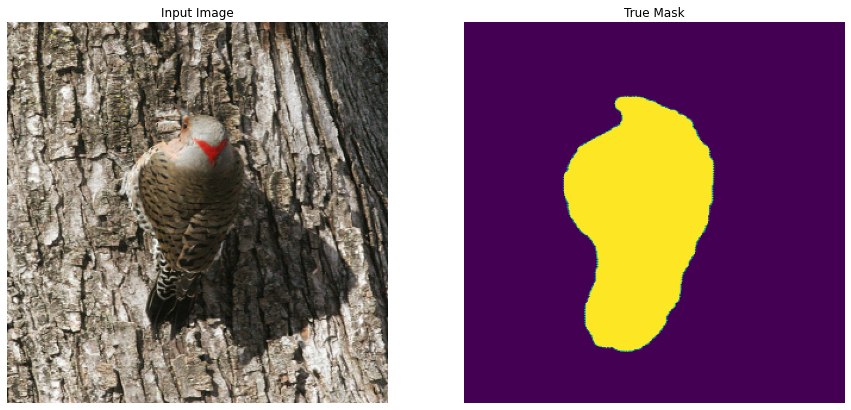

In [ ]:
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    
display([sample_image, sample_mask])

# Model Creation

In [ ]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = True
model = tasm.ACFNet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

43950080/43941136 [==============================] - 0s 0us/step


## Define optimizer, losses, metrics and callbacks

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

metrics = [tasm.metrics.IOUScore(threshold=0.5)]

categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

# Training

In [ ]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

model: True
atrous_spatial_pyramid_pooling_v3: True
dropout: True
convolution_bn_activation_1: True
dropout_1: True
convolution_bn_activation_2: True
att_cf__module: True
concatenate: True
convolution_bn_activation_3: True
dropout_2: True
convolution_bn_activation_4: True
up_sampling2d: True


In [ ]:
start_time = time()
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=callbacks
    )

print(f"Model training took {time() - start_time} seconds.")

Epoch 1/3
187/187 [==============================] - 86s 457ms/step - loss: 0.7436 - iou_score: 0.3342 - val_loss: 1.0409 - val_iou_score: 0.0871 - lr: 0.1000
Epoch 2/3
187/187 [==============================] - 83s 443ms/step - loss: 0.7345 - iou_score: 0.3374 - val_loss: 1.2812 - val_iou_score: 0.0804 - lr: 0.1000
Epoch 3/3
187/187 [==============================] - 83s 445ms/step - loss: 0.7286 - iou_score: 0.3344 - val_loss: 1.1175 - val_iou_score: 0.0804 - lr: 0.1000
Model training took 252.06277322769165 seconds.


# Computing Inference Time on 2500 examples

In [ ]:
# iou_scores = 0
start_time = time()
for image, mask in test.take(2500):
    output_model = model.predict(image[tf.newaxis, ...])

print(f"2500 predictions took about {time() - start_time} seconds.")f

2500 predictions took about 282.7131562232971 seconds.
